# Notebook assigment

# Motivation


* What is your dataset?

* Why did you choose this/these particular dataset(s)?

* What was your goal for the end user’s experience?

Our data resolves around music. We have four different types of data sets. 

________

The first, is a ranked list of songs (with the artist of the song) which have been spending the most time on the spotify U.S. charts counting in the period 2013-2023, https://kworb.net/spotify/country/us_weekly_totals.html. The list is ranking 7653 different songs. This data set is used to get a list of artist primarily singing in the English language. By taking the set of these, 1250 unique artist from the top charts are left, who all at least has had one major song. This ensures that at least some lyrics of these artists are able to be found. We hope to generalize some of the findings on this sample of artists, however, the use of these artists will be discussed later. 

Also, data is collected from the spotify-API, https://developer.spotify.com/documentation/web-api. Here, the genres of the artist are collected as well as the features of that artist. The features enables us to make connections between artists, and by using the genres of the artist a broader analysis can be made.
Finally, the lyrics from the three most popular songs of each artist are collected in order to do text analysis, collected from Genius, https://docs.genius.com.

The main research questions for the project are: 

1. Artists under which genres have the most collaborations?
2. Are collaborations most likely to happen between artists within the same genre and which collaborations are most likely to happen between artists in the largest genres?
3. Which differences in the genres can be found, specifically when looking at the language?



# Basic stats. Let’s understand the dataset better


* Write about your choices in data cleaning and preprocessing
    

* Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

_________

A number of assumptions are done to get to the final data set, which is used to form the network and make basic descriptive stats. The most important preprocessing involves getting the top-genre for each artist, since spotify can associate multi genres per artist. This will be elaborated after the loading of the data.



## _Get dependencies_

In [55]:
import math
import json
import requests
import itertools
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import json
import base64
import itertools
from tqdm.auto import tqdm
import pickle
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain
import netwulf as nw
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")

## _Load data_

### 1. Top charts artist
Loading of the ranked top charts and the artist of the songs into a dataframe - we take the set of artists:

In [5]:
df_charts_artist = pd.read_csv('artists_charts.csv')
unique_artists = df_charts_artist['artist'].unique()


### 2. and 3. Features and Genres

We read the spotify features and genres for each artist into two dictionaries:

In [6]:
def read_files(preprocess=False):
    if not input:
        with open('dict_featuresALL.pickle', 'rb') as handle:
            dict_features = pickle.load(handle)

        with open('dict_genresALL.pickle', 'rb') as handle:
            dict_genres = pickle.load(handle)
        return dict_features, dict_genres
    else:
        with open('dict_featuresPreProcessed.pickle', 'rb') as handle:
            dict_features = pickle.load(handle)

        with open('dict_genresPreProcessed.pickle', 'rb') as handle:
            dict_genres = pickle.load(handle)
            
    return dict_features, dict_genres
    
dict_features, dict_genres = read_files(False)

### 4. We read the lyrics/text part into ...

....

....

## _Preprocessing and Decriptive dataanalysis_

### 1. Top charts artist

In [72]:
df_charts_artist.head(5)

,artist,song
0,Post Malone,Sunflower
1,Juice WRLD,Lucid Dreams
2,Lil Uzi Vert,XO TOUR Llif3
3,J. Cole,No Role Modelz
4,Post Malone,rockstar


As it can be seen Post Malone's song: "Sunflower" has spend the most time on the U.S. top charts. The general statistics from the dataframe can be seen below:

In [8]:
df_charts_artist.describe()

,artist,song
count,7651,7650
unique,1250,6922
top,Drake,Intro
freq,205,8


There are 7651 artist and 1250 unique ones. Drake appear the most on this list with 205 songs. One song seem to be missing since there are 7650 songs. Songs with the same name appears on the list, with eight songs called: "Intro". A common title for the first song on an album. 

### 2. Features

The features are assembled by collecting every spotify song of the artist which has a list of performers on the track. We have assumed that all remixes of a song is a seperate song and the features from a specific song and the remixed songs will therefore be collected. This might seem like an unreasonable assumption since it is not exactly a new collaboration between the artists, that some extra bass is added to the song. However, artists often form a song, and then later make a "remix" which includes a new feature on it. Thus, we go with remixes as well to not miss out on fair collaborations.


The features for 5 random songs for each artist: 

In [14]:
dict_features_copy = {}
for k,v in dict_features.items():
    only_names = [va[0] for va in v]
    dict_features_copy[k[0]] = only_names

# pd dataframe from dict_features
df_features = pd.DataFrame.from_dict(dict_features_copy, orient='index')
df_features.T.head()

,Post Malone,Juice WRLD,Lil Uzi Vert,J. Cole,Travis Scott,The Weeknd,XXXTENTACION,Lil Baby,Kendrick Lamar,Glass Animals,...,Third Eye Blind,My Morning Jacket,Kid Rock,Jarryd James,Rebel Wilson,Ciara,Christina Aguilera,The Temptations,Death Cab for Cutie,Purity Ring
0,Roddy Ricch,Justin Bieber,Future,Dreamville,ROSALÍA,Daft Punk,Ski Mask The Slump God,Nardo Wick,Blxst,Denzel Curry,...,Alexis Krauss,None,Monster Truck,Trapo,Andrew Lloyd Webber,Macklemore,Lil' Kim,K. Sparks,None,Young Magic
1,Doja Cat,Polo G,Future,JID,Lil Baby,Lana Del Rey,PnB Rock,Young Thug,Amanda Reifer,Hudson Mohawke,...,None,None,Robert James,BROODS,"Cast Of The Motion Picture ""Cats""",Kelly Rowland,Redman,Smokey Robinson,None,Deftones
2,Gunna,Trippie Redd,Future,Kenny Mason,Sheck Wes,Kendrick Lamar,Trippie Redd,Fridayy,Sampha,Raz & Afla,...,None,None,Martina McBride,Raury,Robbie Fairchild,Tekno,Becky G,John Forte,None,Deftones
3,Fleet Foxes,SUGA,Future,Sheck Wes,Don Toliver,Future,Lil Wayne,Future,Taylour Paige,Kelly Lee Owens,...,None,None,T.I.,Julia Stone,Jason Derulo,Pitbull,Nicki Nicole,Four Tops,None,Deftones
4,The Kid LAROI,BTS,Future,Dreamville,Quavo,Daft Punk,Rick Ross,Rylo Rodriguez,Summer Walker,Denzel Curry,...,None,None,Sheryl Crow,None,James Corden,Missy Elliott,NATHY PELUSO,Rick James,None,Deftones


However, this data has to be processed. Some of the features are not included in the list of top charts' artists. We remove the features not being present in this list, and check the difference in the data from before:

In [31]:
dict_features_ = {}
for k,v in dict_features.items():
    # remove v elements which are in list_of_artist_with_no_genre
    dict_features_[k] = [artist for artist in v if artist in dict_features.keys()]

In [32]:
dict_features_copy = {}
for k,v in dict_features_.items():
    only_names = [va[0] for va in v]
    dict_features_copy[k[0]] = only_names

# pd dataframe from dict_features
df_features = pd.DataFrame.from_dict(dict_features_copy, orient='index')
df_features.T.head()

,Post Malone,Juice WRLD,Lil Uzi Vert,J. Cole,Travis Scott,The Weeknd,XXXTENTACION,Lil Baby,Kendrick Lamar,Glass Animals,...,Third Eye Blind,My Morning Jacket,Kid Rock,Jarryd James,Rebel Wilson,Ciara,Christina Aguilera,The Temptations,Death Cab for Cutie,Purity Ring
0,Roddy Ricch,Justin Bieber,Future,Dreamville,Lil Baby,Daft Punk,Ski Mask The Slump God,Nardo Wick,Blxst,Denzel Curry,...,None,None,T.I.,None,Jason Derulo,Macklemore,Becky G,Rick James,None,ScHoolboy Q
1,Doja Cat,Polo G,Future,JID,Sheck Wes,Lana Del Rey,PnB Rock,Young Thug,Summer Walker,Denzel Curry,...,None,None,Snoop Dogg,None,Taylor Swift,Pitbull,Ozuna,None,None,Ab-Soul
2,Gunna,Trippie Redd,Future,Sheck Wes,Don Toliver,Kendrick Lamar,Trippie Redd,Future,Kodak Black,iann dior,...,None,None,None,None,Taylor Swift,Missy Elliott,Demi Lovato,None,None,A$AP Rocky
3,The Kid LAROI,BTS,Future,Dreamville,Quavo,Future,Lil Wayne,Jeremih,Baby Keem,Denzel Curry,...,None,None,None,None,None,T.I.,GoldLink,None,None,Charli XCX
4,The Weeknd,Lil Uzi Vert,Future,2 Chainz,Offset,Daft Punk,Rick Ross,EST Gee,SZA,None,...,None,None,None,None,None,Pitbull,Ty Dolla $ign,None,None,None


Some artists have been removed as expected. 

The descriptive statistics tells us each artist's favorite feature on his/her/their songs and how many times they appear:

In [33]:
df_features.T.describe()

,Post Malone,Juice WRLD,Lil Uzi Vert,J. Cole,Travis Scott,The Weeknd,XXXTENTACION,Lil Baby,Kendrick Lamar,Glass Animals,...,Third Eye Blind,My Morning Jacket,Kid Rock,Jarryd James,Rebel Wilson,Ciara,Christina Aguilera,The Temptations,Death Cab for Cutie,Purity Ring
count,36,36,51,153,48,34,22,80,36,4,...,0,0,2,0,3,27,10,1,0,4
unique,23,16,12,33,18,18,10,21,25,2,...,0,0,2,0,2,14,10,1,0,4
top,Quavo,Future,Future,Dreamville,Quavo,Daft Punk,Ski Mask The Slump God,Lil Durk,Ab-Soul,Denzel Curry,...,NaN,NaN,T.I.,NaN,Taylor Swift,Missy Elliott,Becky G,Rick James,NaN,ScHoolboy Q
freq,3,15,36,69,15,5,8,19,3,3,...,NaN,NaN,1,NaN,2,4,1,1,NaN,1


### 3. Genres
Here are both "all genres" for each artist (determined by spotify) and the top genre (determined by us):

In [34]:
dict_genres_copy = {}
for k,v in dict_genres.items():
    dict_genres_copy[k[0]] = v
pd.DataFrame.from_dict(dict_genres_copy).head()

,Post Malone,Juice WRLD,Lil Uzi Vert,J. Cole,Travis Scott,The Weeknd,XXXTENTACION,Lil Baby,Kendrick Lamar,Glass Animals,...,Third Eye Blind,My Morning Jacket,Kid Rock,Jarryd James,Rebel Wilson,Ciara,Christina Aguilera,The Temptations,Death Cab for Cutie,Purity Ring
all_genres,"[dfw rap, melodic rap, pop, rap]","[chicago rap, melodic rap, rap]","[melodic rap, philly rap, rap]","[conscious hip hop, hip hop, north carolina hi...","[hip hop, rap, slap house]","[canadian contemporary r&b, canadian pop, pop]","[emo rap, miami hip hop]","[atl hip hop, atl trap, rap, trap]","[conscious hip hop, hip hop, rap, west coast rap]","[gauze pop, indietronica, modern rock, shiver ...",...,"[alternative metal, pop rock, post-grunge]","[chamber pop, indie rock, jam band, louisville...",[nu metal],"[australian alternative pop, australian r&b]",[australian comedy],"[dance pop, hip pop, pop, r&b, urban contempor...","[dance pop, pop]","[memphis soul, motown, soul]","[alternative rock, chamber pop, indie rock, in...","[canadian electropop, dark pop, edmonton indie..."
top genre,rap,rap,rap,hip-hop,rap,pop,rap,trap,rap,pop,...,poriginal-soundtrack-grunge,indie,metal,r&b,comedy,pop,pop,soul,indie,pop


Since the genre is important for the rest of the work, we will look into how the top genre was formed by us. First we define a plot function to help us visualize the preprocessing:

In [35]:
def make_hist_of_genres(dict_genres, key_to_use: str, top_n= 20):
    list_of_genres = []
    for dict in dict_genres.values():
        list_of_genres.append(dict[key_to_use])

    if key_to_use == 'all_genres':
        all_genres = list(itertools.chain(*list_of_genres))
        
    else:
        all_genres = list_of_genres
    # Make the plot with seaborn
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,3))
    ax = sns.countplot(x=all_genres, order=pd.value_counts(all_genres).iloc[:top_n].index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    props = {'boxstyle': 'round', 'facecolor': 'grey', 'alpha': 0.5}

    # place a text box in upper left in axes coords
    if key_to_use == 'all_genres':
        plt.title(f'Top {top_n} genres (all genres)', fontsize=20)
        ax.text(0.67, 0.92, f' Number of genres collected:  {3623} \n Number of unique genres:      {569}', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    else: 
        plt.title(f'Top {top_n} genres (top genres)', fontsize=20)
        ax.text(0.67, 0.92, f' Number of genres collected:  {1147} \n Number of unique genres:      {102}', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.show()
    
    return all_genres

We plot the distribution of "all genres" for the 20 most frequent
:

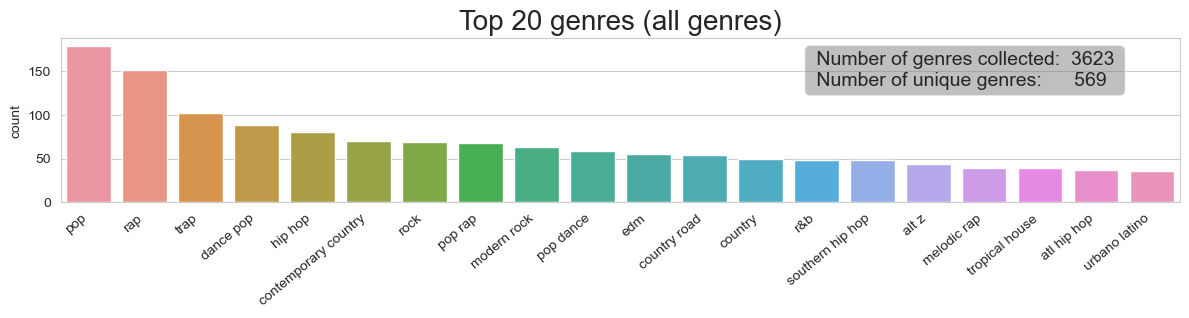

In [36]:
all_genres = make_hist_of_genres(dict_genres, 'all_genres')

On average each artist has around 3 different genres associated with them. The task is now to form exactly one genre per artist, i.e. the top genre. 
From the plot it can be seen that 103 artists have no genre. These will be removed. 
It is also visible that many genres somewhat overlap. For example, "contemporary country" and "country road" can be considered genres under "country". The idea is that we do not differentiate between types under a broader genre. Some might argue that rap is a genre under hip-hop, however, we also try to avoid deleting too many genres. 

By splitting each artist genres into word tokens, we can for example count how many times the word "pop" and "r&b" appears, and then take the most frequent one-word genre - where the genres defined are the ones spotify have defined. This is an example from the artist "The Weeknd":


In [37]:
artist_str, value_str, splitter_str = 'The Weeknd', 'all_genres', ' '
print(f'All genres from The Weeknd:                                                         {dict_genres_copy[artist_str][value_str]}')
print(f'Split by words. Word tokens:                                                        {list(itertools.chain(*[genre.split(splitter_str) for genre in dict_genres_copy[artist_str][value_str]]) )}')
print(f'Count frequent word tokens. Counted Word tokens:                                    {Counter(list(itertools.chain(*[genre.split(splitter_str) for genre in dict_genres_copy[artist_str][value_str]]) )).most_common()}')
print('Check if the most frequent word tokens are in a defined list of genres. Top-genre:  [\'pop\']')


All genres from The Weeknd:                                                         ['canadian contemporary r&b', 'canadian pop', 'pop']
Split by words. Word tokens:                                                        ['canadian', 'contemporary', 'r&b', 'canadian', 'pop', 'pop']
Count frequent word tokens. Counted Word tokens:                                    [('canadian', 2), ('pop', 2), ('contemporary', 1), ('r&b', 1)]
Check if the most frequent word tokens are in a defined list of genres. Top-genre:  ['pop']


Exceptions are which can arise:
* Having multiple word tokens which are genres. Here, we choose randomly. 
* Having a genre, but no word tokens fit with the defined list of genres. Solved by choosing randomly from the list of all genres without splitting into word tokens. 
* Having zero genres. These are removed.

The function/code used to define the top genres can be found here: **LINK LINK LINK**

We load the updated data, not including artist without a genre:

In [38]:
dict_features_updated, dict_genres_updated = read_files(True)

Let's visualize the top 20 most frequent genres again, and see how many genres are left after the preprocessing:

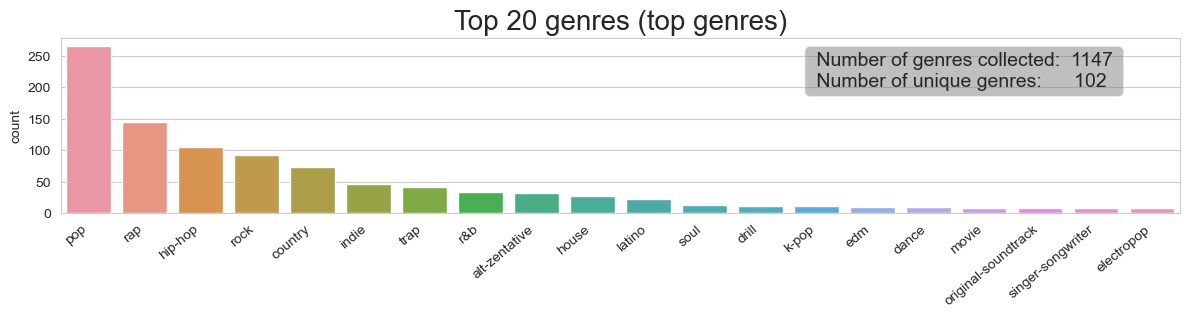

In [39]:
top_genres = make_hist_of_genres(dict_genres, 'top genre')

The number of genres both collected and being unique is reduced, and the top genre is now defined!

### 4. Text 


Now to text ....

...

# Tools, theory and analysis. Describe the process of theory to insight


Talk about how you’ve worked with text, including regular expressions, unicode, etc.

Describe which network science tools and data analysis strategies you’ve used, how those network science measures work, and why the tools you’ve chosen are right for the problem you’re solving.

How did you use the tools to understand your dataset?

________________


The natural order of this project is to first look at the methods for the network formed and then the methods for the text.

**Network**

We will be forming an undirected network with the nodes as artists and the edges formed by features, where the weight of the edge is the number of features going both ways (we will use the word "collaborations" through-out the text). First of all, we will be visualizing degree distribution of the network in order to determine how common features are between artist. 

In order to determine if the links between artist can be explained by the top genres (hypothesis: "musicians are most likely to collaborate with artist within their own genre), the modularity measure of the network will be used. This metric measures the how good a partition the genres are. A large modularity would suggest that the genres does describe the collaborations between artists.
This can be compared to random networks using the double edge swap algorithm. The double edge swap algorithm preserves the degrees of the nodes (number of features of an artist). Thus, ensures the same graph structure, therefore making the simulated graphs possible to compare to the original one. It is therefore possible to compare with the original graph based on the question: "What if each artist links/features were random?".
Hence, we are able to determine if the modularity of the genre partition is significantly different from the random edges. 

The optimal partitioning can be found by the Louvain-algorithm. By using this, we can investigate if there exists a better partitioning of the graph. If so, we are able to analyze the louvain-algorithms partitions, and if they seem to suggest inter-genre features. This can be done with a confusion matrix comparing he genre partitioning and the best partitioning.



**Text**


....

## _Network analysis_

The following section will walk-through the forming of the network and the analysis of it.

### 1. Form the network

First, we define a function to make the described network with the attribute "group" being the top genre. Second, we form the network.

In [51]:
def make_network(dict_features_updated, dict_genres_updated, islimitedartists=True):
    """Function to make graph from dict of features. Edges will be features. The weight is features shared between artists."""
    G = nx.Graph()
    for artist in dict_features_updated.keys():
        artist_name = artist[0]
        artist_id = artist[1]

        if dict_genres_updated[(artist_name,artist_id)]['top genre'] in ['pop', 'rap', 'hip-hop', 'rock', 'country']:
            G.add_node(artist_name, label=artist_id, group={'pop': 'blue', 'rap': 'orange', 'hip-hop': 'green', 'rock': 'red', 'country': 'purple'}[dict_genres_updated[(artist_name,artist_id)]['top genre']])

        else:
            G.add_node(artist_name, label=artist_id, group=dict_genres_updated[(artist_name,artist_id)]['top genre'])
        # exclude nodes removed since no genre
        
        res = Counter(dict_features_updated[artist])
        for key in res.keys():
            if key in dict_features_updated.keys() and islimitedartists:
                if G.has_edge(artist_name, key[0]):
                    G.get_edge_data(artist_name, key[0])['weight'] += res[key]
                else:
                    G.add_edge(artist_name, key[0], weight=res[key])
    return G

In [52]:
G_artist = make_network(dict_features_updated, dict_genres_updated, islimitedartists=True)

### 2. Properties of the network - degrees


We first define a plotting function.

In [42]:
def plot_distribution_of_degrees(G_artist):
    dict_degrees_per_genre = {}
    top5_genres = ['pop', 'rap', 'hip-hop', 'rock', 'country']
    for genre_type in top5_genres:
        dict_degrees_per_genre[genre_type] = np.array([G_artist.degree(x, weight='weight') for x,y in G_artist.nodes(data=True) if y['group']==genre_type])


    list_all_degrees= np.array([v for k,v in G_artist.degree(weight='weight')])


    dict_colors = {'pop': 'blue', 'rap': 'orange', 'hip-hop': 'green', 'rock': 'red', 'country': 'purple'}
    # Make two histograms of the degree distribution with subfigures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    for genre_type in 'pop', 'rap', 'hip-hop', 'rock', 'country':
        sns.histplot(dict_degrees_per_genre[genre_type]+1,ax=ax2, label=genre_type, stat='percent', element='poly', fill=True, alpha=0.2, log_scale=True)
        ax2.vlines(np.mean(dict_degrees_per_genre[genre_type]), ymin= 0, ymax= 45, linestyles='dashed', label=f'mean: {np.mean(dict_degrees_per_genre[genre_type]):.0f}', colors=dict_colors[genre_type], alpha=0.5)

    ax2.legend()
    ax2.set_title('Degree distribution for each genre')
    sns.histplot(list_all_degrees+1, ax=ax1, label='All artists', stat='percent', element='poly', fill=True, alpha=0.2, log_scale=True, color='mediumturquoise')
    ax1.vlines(np.mean(list_all_degrees), ymin= 0, ymax= 22, linestyles='dashed', label=f'mean: {np.mean(list_all_degrees):.0f}', colors='mediumturquoise', alpha=0.5)

    ax1.set_title('Degree distribution for all artists')
    ax1.legend()

    plt.show()

The distribution of the degrees of the network in percentage are plotted below. The first plot shows the distribution of all artists' degrees. The second histogram shows the distribution of the degrees for each of the top 5 genres' artist.

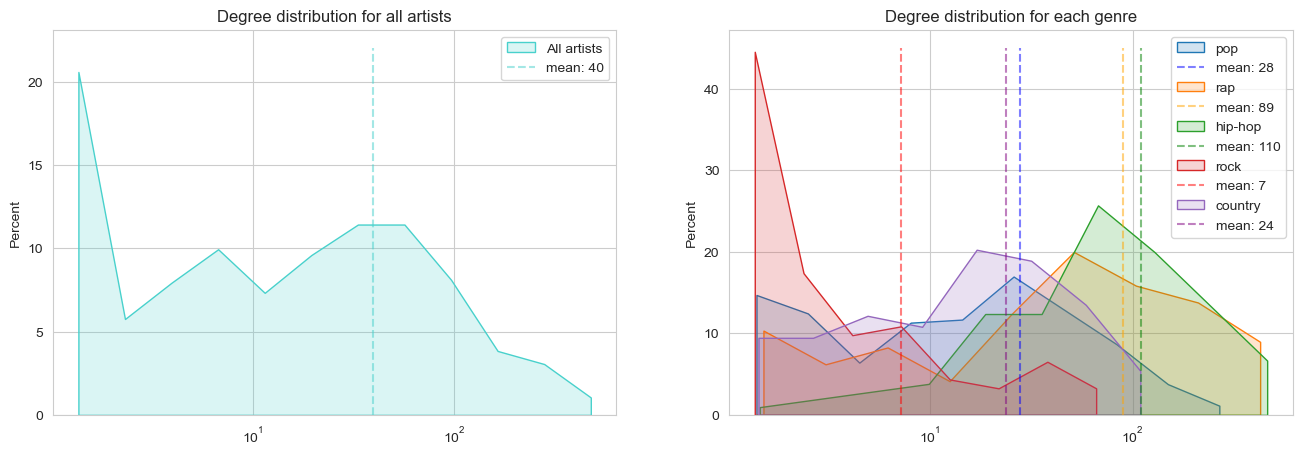

In [43]:
plot_distribution_of_degrees(G_artist)


The first graph shows that the distribution of degrees is right-skewed (note the log-scale). This means that many artist have very few features, however, a small amount of artists have significantly more features. The mean of the degrees is 40. The dis-continuous histogram might suggest that more insights about the structure can be gained by isolating the artists' genres. 

The second graph exactly shows this. The distributions for each of the top 5 genres proves that there exists differences of the degrees for each genre. The artist in the rock genre (red) have significantly less collaborations than in the other four genres with a mean of 7. The distribution is heavily right-skewed. Pop and country has similar distributions and their means of 28 and 24 lie under the all artists' mean. Finally, the two genres rap and hip-hop have means of 89 and 110 and are pulling the overall mean upwards. The distributions are less right-skewed (again remember the log-scale), thus it is more common within these genres to have a higher number of collaborations. While the hip-hop genre has higher mean and relatively less artists with fewer than 10 collaborations, the two distributions are relatively similar. This might be expected, since (at least for us) the genres are hard to stricly differ. 

If we plot the top 15 artists with the most collaborations, it is visible that most of these are artists under the genre "hip-hop" or "rap":

In [44]:
list_names_and_degrees = [(k,v,g[1]) for (k,v),g in zip(G_artist.degree(weight='weight'),G_artist.nodes(data='group'))]
df_top_collaborators = pd.DataFrame(list_names_and_degrees, columns=['artist name', 'number of features', 'genre']).sort_values(by='number of features', ascending=False).T
df_top_collaborators.columns = range(1,len(list_names_and_degrees)+1)
df_top_collaborators.loc[:, :15]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
artist name,Future,Lil Wayne,Young Thug,Gucci Mane,French Montana,Rick Ross,Lil Durk,Juicy J,DJ Drama,Metro Boomin,Mac Miller,Drake,2 Chainz,Ty Dolla $ign,DJ Khaled
number of features,603,569,549,501,455,389,371,370,367,365,363,355,353,348,348
genre,hip-hop,rap,rap,hip-hop,hip-hop,rap,drill,hip-hop,rap,trap,rap,hip-hop,hip-hop,hip-hop,rap


### 3. Visualize network

The graph can be visualized with netwulf and the saved image is seen below. The five top genres have the same color as above. Besides that the lime-green color is trap-artists:

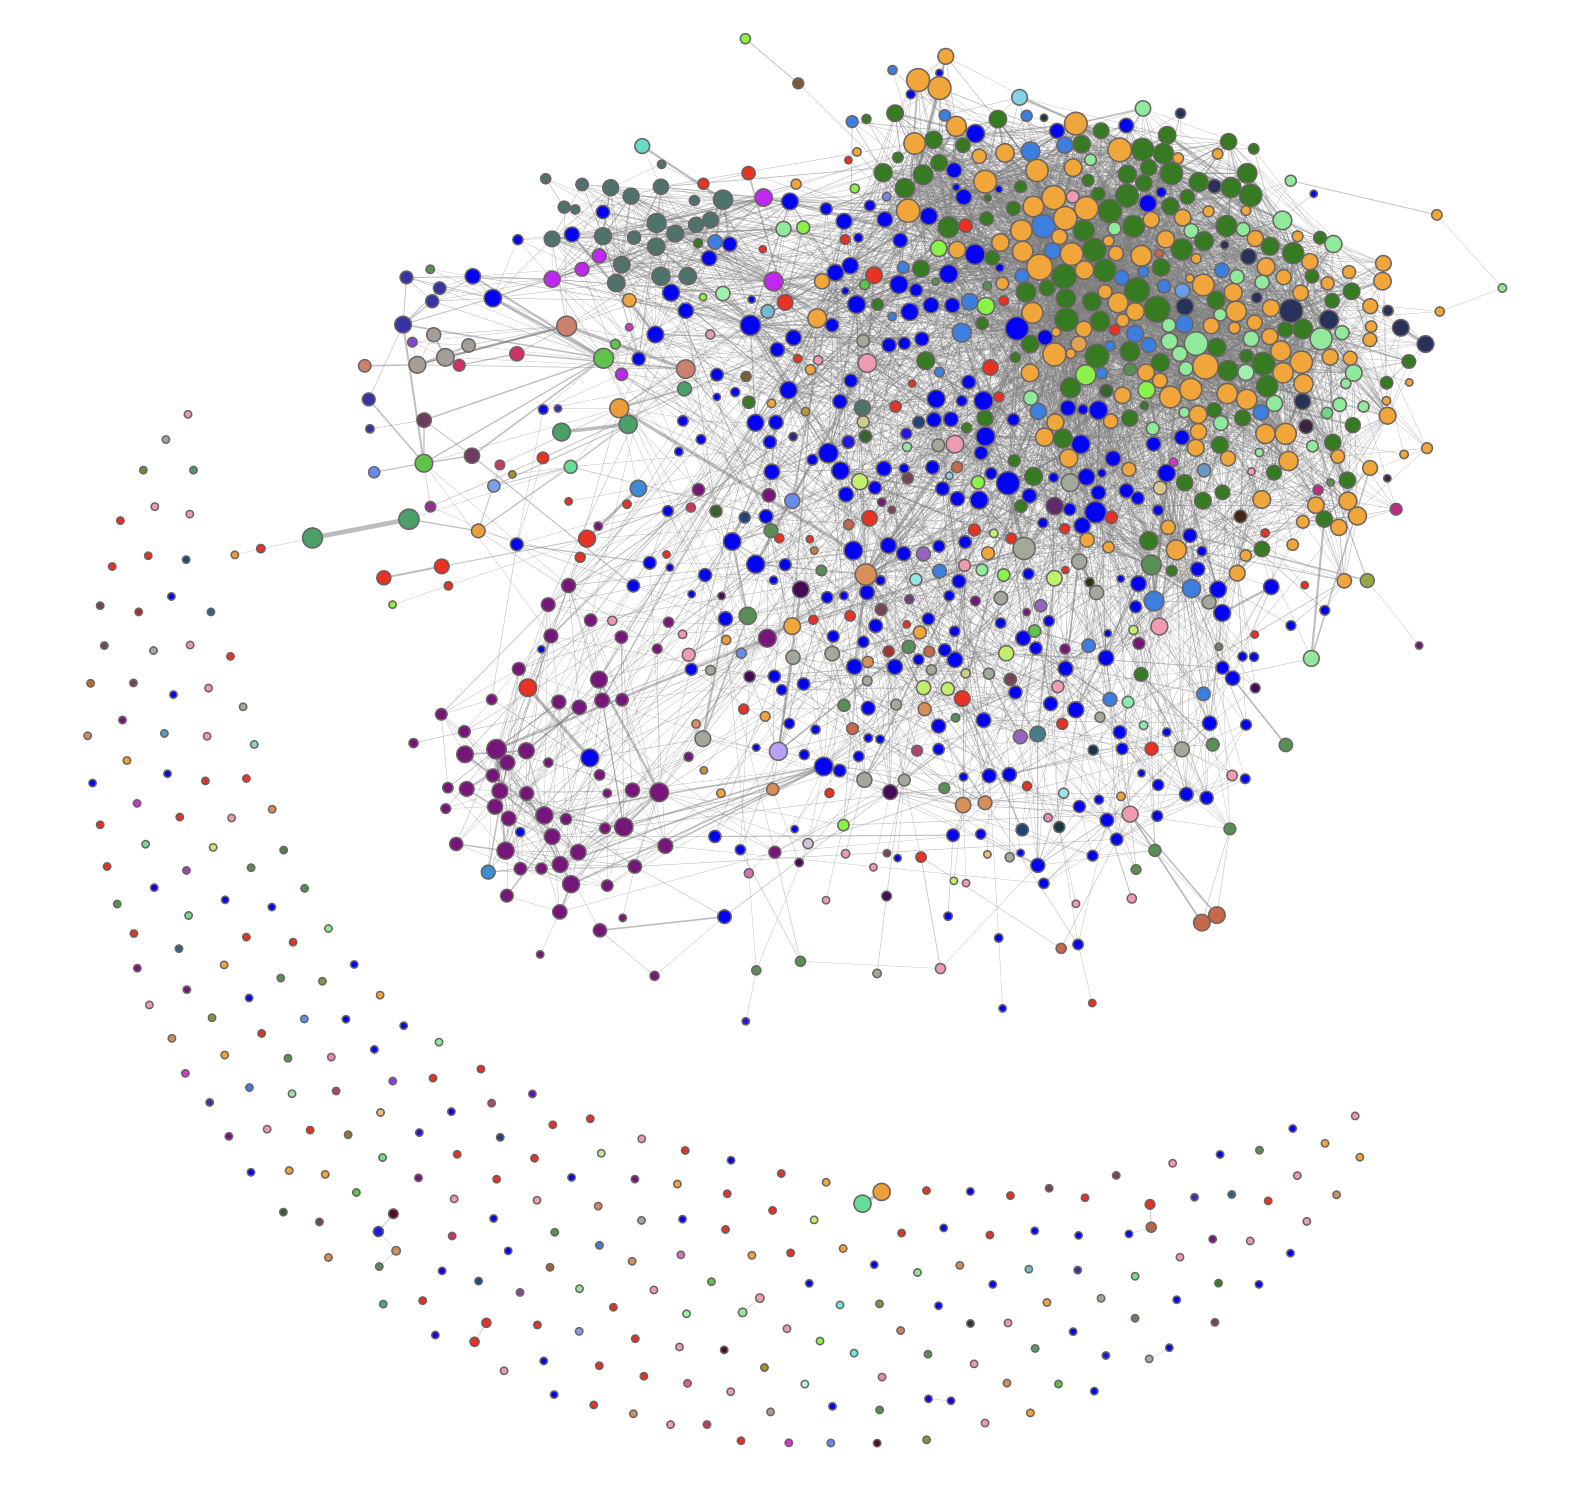

In [54]:
path = 'images/graph.png'
display(Image(filename=path, width=500, height=500))

### 4. Analysis of modularity

We wish to investigate the modularity of the network inorder to access the likelihood of collaborations happening within the genre and inbetween genres.

First, we define a helper-function making the partitions:

In [61]:
def PartitioningGeneral(partion_dict):
    groups_dict = {key: [] for key in set(list(partion_dict.values()))}
    for instance in list(partion_dict.items()):
        groups_dict[instance[1]].append(instance[0])

    return list(groups_dict.values())

We need calculate the modularity of the genre partitioning and use the double edge swap to calculate 1000 modularities for random graphs:


In [63]:
dict_genres_partition = {k[0]: v['top genre'] for k, v in dict_genres_updated.items()}
partition_genres = PartitioningGeneral(dict_genres_partition)
modularity_genre = nx.community.modularity(G_artist, partition_genres)


GGG_copy = G_artist.copy()
list_modu = []
for _ in tqdm(range(1000)):
    G_swapped = nx.double_edge_swap(GGG_copy, nswap=G_artist.number_of_edges()*2, max_tries=1000000, seed=27)
    modu = nx.community.modularity(G_swapped, partition_genres)
    list_modu.append(modu)

It is now possible to visualise the distribution of the modularities for the random graphs and the one for the genre partitioning:

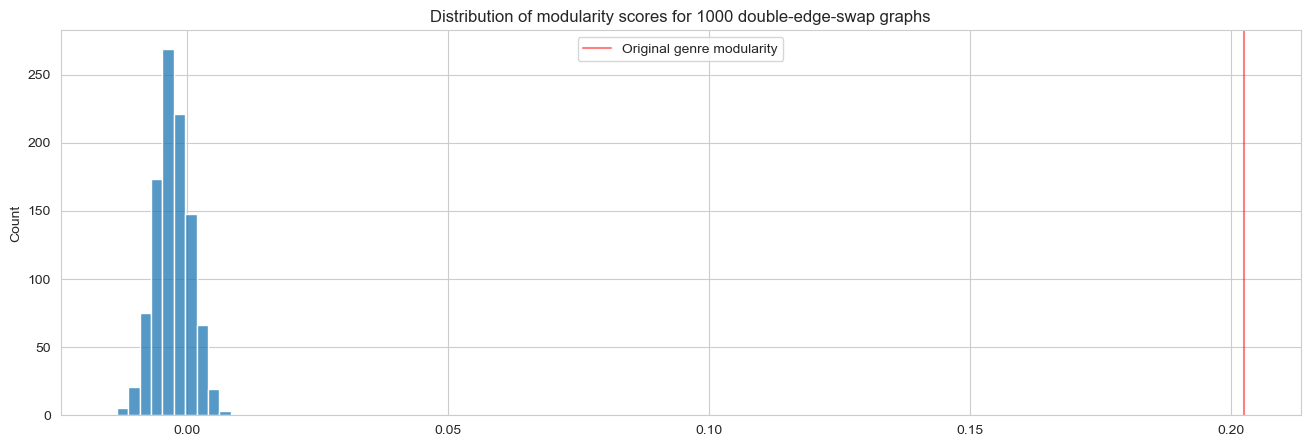

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
sns.histplot(list_modu,bins=10)
plt.axvline(modularity_genre, c='red', label='Original genre modularity', alpha=0.5)
#plt.axvline(modularity_louvain, c='green', label='The Louvain partitions modularity')
plt.title('Distribution of modularity scores for 1000 double-edge-swap graphs')
plt.legend(loc=9)
plt.show()

It is visible from the plot, that the modularity of the genre partitioninng on the graph is significantly different from the random graphs' modularities. Hence, the genres does somewhat form meaningful groups in the network in terms of the connections being collaborations. However, it is reasonable to investigate if a better partitioning exists. This will be done in the following section.

### 5. Community detection

We use the Louvain algorithm to find the best partition of the graph.

In [64]:
dict_louvain_partition = community_louvain.best_partition(G_artist)
partition_louvain = PartitioningGeneral(dict_louvain_partition)
modularity_louvain = nx.community.modularity(G_artist, partition_louvain)
print('',f'Genre   ---   modularity: {modularity_genre:.2f}', '   number of groups:', len(partition_genres), \
       '\n', f'Louvain ---   modularity: {modularity_louvain:.2f}', '   number of groups:', len(partition_louvain)) 


 Genre   ---   modularity: 0.20    number of groups: 101 
 Louvain ---   modularity: 0.56    number of groups: 262


The Louvain modularity is significantly higher, meaning that better partitions exist. It can be seen by the number of groups of the Louvain partitions, that more communities exist within the graph. We can compare these partitions in the next section.

### 6. Comparing partition

A confusion matrix of the largest eight communities from the genre and best partition can help us determine the differences and similarities between the two.

We define two helper functions to make the plot:

In [65]:
def GetMatrix(communities1, communities2):
    fulllist = []
    for l1 in communities2:
        appendlist = []
        for l2 in communities1:
            appendlist.append(len(list(set(l1) & set(l2))))
        fulllist.append(appendlist)
    np.array(fulllist)
    return np.array(fulllist)

def PartitioningGeneral_adj(partion_dict):
    groups_dict = {key: [] for key in set(list(partion_dict.values()))}
    for instance in list(partion_dict.items()):
        groups_dict[instance[1]].append(instance[0])

    return groups_dict

Now we form the confusion matrix of the eight largest communities - the x-axis are the genres and y-axis are the louvain genres:


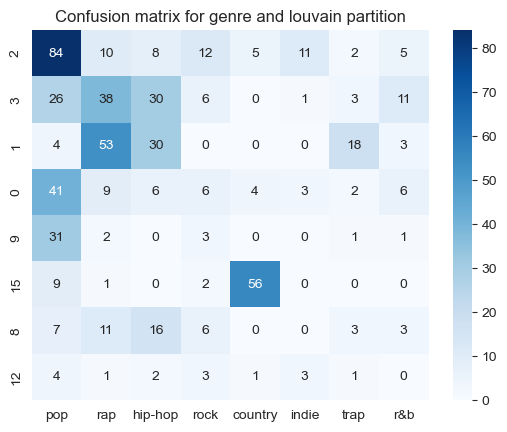

In [40]:
# make matrix
M = GetMatrix(partition_genres,partition_louvain)
# Get top 5 genres
largest_genres_idx = M.sum(axis=0).argsort()[-8:][::-1]
largest_genre_names = [list(PartitioningGeneral_adj(dict_genres_partition).keys())[i] for i in largest_genres_idx]
# Get top 5 louvain partitions
largest_louvain_idx = M.sum(axis=1).argsort()[-8:][::-1]
largest_louvain_names = [list(PartitioningGeneral_adj(dict_louvain_partition).keys())[i] for i in largest_louvain_idx]

sns.heatmap(M[largest_louvain_idx,:][:,largest_genres_idx], annot=True, cmap='Blues',xticklabels=largest_genre_names, yticklabels=largest_louvain_names)
plt.title('Confusion matrix for genre and louvain partition')
plt.show()

It should be noted that the matrix only contains a smaller part of the 101x262 matrix. However, multiple things can be analysed from the plot. 

Best partition group 0, 2 and 9 mostly consists of artists from the pop genre. This is a sign that groups exists within this genre, hence, some groups of pop artists are more likely to collaborate. 

Group 3 is notable since it consists of a large group of pop artists from the pop, rap and hip-hop genre. Else, there is a tedency that rap and hip-hop artists are more likely to collaborate. Group 1 suggests that trap is somewhat included in this community. 
This makes sense since the genres are closely related, and when defining the top genre of artists it was common to find a draw between rap and hip-hop (making it a random decision).

Not a lot of rock artists are included in the 8 largest groups and there is no clear sign which other genres rock artist collaborate with, maybe pop. Country artists has one large group 15 suggesting that they are likely to feature on songs within their own genre. 


These are some of the most visible conclusion to be made from the confusion matrix. 

### 7. Louvain-partition's network visulized

The Louvain partition's network can be visuallized as well to get a broader view over the differences in the communities. The two network are plotted beside each other:

In [68]:
# Make a similar graph but with the group of the nodes being the louvain partition
G_artist_louvain = G_artist.copy()
for node in G_artist_louvain.nodes():
    G_artist_louvain.nodes[node]['group'] = dict_louvain_partition[node]


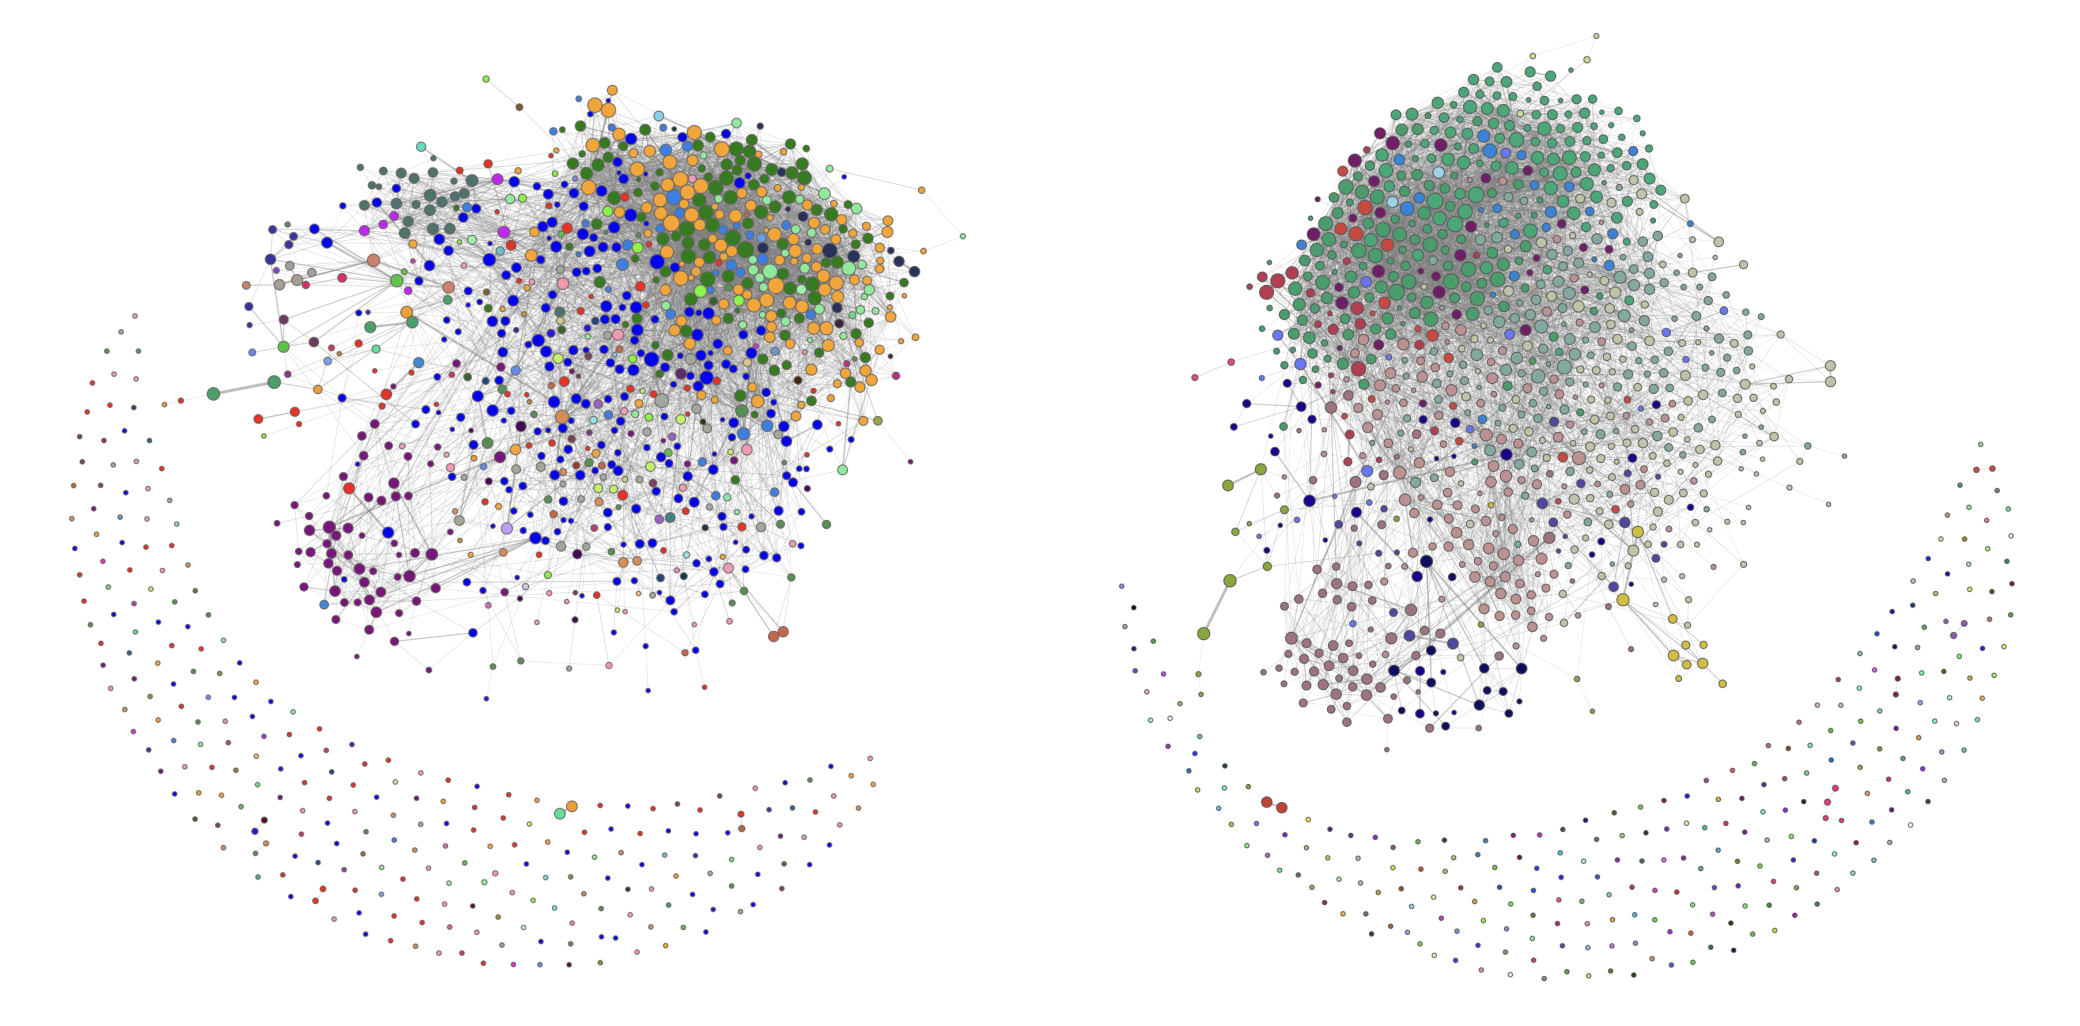

In [70]:
path = 'images/graph_both.png'
display(Image(filename=path, width=800, height=800))

The most profound difference is the amount of rap and hip-hop artists which is primarily forming one large group in the network, proving our analysis of from the confusion matrix right. Else, it is generally visiable that the partitions to the right are better at describing the collaborations. 

## _Text_

INSERT TEXT


# Discussion. Think critically about your creation



What went well?

What is still missing? What could be improved? Why?

_________


Regarding improvements of the project, some assumptions are made. The analysis is made on artists topping the charts for a long time. We somewhat assume this group to represent their genre well, to make conclusions on these. This assumption can be discussed, and it is likely that a larger number of artists would improve our analysis, since a larger sample size makes the sample closer to the population of data points - however, most of our analysis involves the top 5-8 genres with relatively many data points. We were surprised by the different types of artists and genres included in the 1250 artists having at least one major song. All this considered, we conluded that the sample of 1250 artists were fair to work with. 

We could have hoped for more precise definitions of genres. Our definitions of top-genre was based of a lot of random decisions between hip-hop and rap for example. However, artists are often hard to put into one specific genre, so it might just be the terms of the task. 


OUR WRITTING